# ATSC-500 Assignment VIII (zeta v.s. phi through Cesar data)

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
from glob import glob
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from dateutil.relativedelta import relativedelta
% matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")
# Colors
B1 = [.35, .35, .35]#[0.31, 0.61, 0.78]
B2 = 'k'#[0.04, 0.23, 0.44]

## Pre-processing

* Data coverage: 2016/01/01 - 2017/02/28
* -9999.0 is identified as missing value
* The original data is averaged for every 20 observations, consistent with **[Verkaik and Holtslag [2007]](https://link.springer.com/article/10.1007%2Fs10546-006-9121-1)**
* Data larger than $u^* < 0.15$ was rejected in Verkaik and Holtslag [2007], but here no critical values were applied.

**A summary of Cesar variables**

| File type | Variable name | key| 
|------|-------|-------|
| Surface flux data | Sensible heat flux $E_H$| H |
| Surface flux data | Latent heat flux $E_H$| LE |
| Surface flux data | Friction velosity $u_*$ | UST |
| Surface meteorological data | 2-m temperature $\overline{T}$ | TA002 |
| Surface meteorological data | 2-m humidity $\overline{T}$ | Q002 |
| Surface meteorological data |Mean atmospheric air pressure $\overline{p}$ | P0 |
| Tower meteorological data | Height $z$ | z |
| Tower meteorological data | Mean wind speed $\overline{U}$ | F |

In [3]:
def QC(data, fillval=-9999):
    '''
    Mask out fillvals
    '''
    data[data == fillval] = np.nan
    return data

def QC_Us(data, critical_val=0.15):
    '''
    Us < critical_val = NaN 
    '''
    data[data<critical_val] = np.nan
    return data

def average_window(data, window_size=20):
    '''
    The length of the output will change
    use np.nanmean, isolated NaNs will be averaged out
    returns average and std as errbar 
    '''
    L0 = len(data)
    L1 = L0//window_size
    L2 = L1*window_size
    data_reshape = data[:L2].reshape(L1, window_size)
    return np.nanmean(data_reshape, 1), np.std(data_reshape, 1)

### Create time coordinates

In [4]:
window_size=20
# creating a list of datetime
base = datetime(2016, 1, 1, 0, 0)
days = (datetime(2017, 2, 28, 23, 50) - base).days + 1
date_list = [base + relativedelta(minutes=x) for x in range(0, days*24*60, 10)] # original freq is 10 min
date_list_ave = [base + relativedelta(minutes=x) for x in range(0, days*24*60, window_size*10)] 
# glob files
twr_names = sorted(glob('_data/ATSC-500/cesar*/cesar_tower_meteo*.nc'))
sfc_names = sorted(glob('_data/ATSC-500/cesar*/cesar_surface_meteo*.nc'))
flx_names = sorted(glob('_data/ATSC-500/cesar*/cesar_surface_flux*.nc'))
[print(name) for name in flx_names];

_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201601.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201602.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201603.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201604.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201605.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201606.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201607.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201608.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201609.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201610.nc
_data/ATSC-500/cesar_surface_flux_201601_201702/cesar_surface_flux_lc1_t10_v1.0_201611.nc
_data/ATSC

### Import + QC + window average

In [5]:
L = len(date_list)
L1 = L//window_size
# get the length of single files
L_single = [0]
for name in twr_names:
    nc_obj = nc.Dataset(name)
    temp_time = nc_obj.variables['time'][:]
    L_single.append(len(temp_time))
    nc_obj.close()
# Allocation
Q0 = np.zeros(L)*np.nan
T0 = np.zeros(L)*np.nan
P0 = np.zeros(L)*np.nan
Hs = np.zeros(L)*np.nan
Hl = np.zeros(L)*np.nan
Us = np.zeros(L)*np.nan
U = np.zeros([L, 7])*np.nan
U_ave = np.zeros([L1, 7])*np.nan
U_std = np.zeros([L1, 7])*np.nan
# Importing tower data
for i, name in enumerate(twr_names):
    inds = sum(L_single[:i+1])
    inde = inds + L_single[i+1]
    nc_obj = nc.Dataset(name)
    U[inds:inde, :] = np.fliplr(nc_obj.variables['F'][:]) # !! <--- original data is top - bottom
    nc_obj.close()
# Import z (assuming all tower data have the same z)
nc_obj = nc.Dataset(name)
z = np.flipud(nc_obj.variables['z'][:])
nc_obj.close()
# Importing surface data
for i, name in enumerate(sfc_names):
    inds = sum(L_single[:i+1])
    inde = inds + L_single[i+1]
    nc_obj = nc.Dataset(name)
    P0[inds:inde] = nc_obj.variables['P0'][:]
    T0[inds:inde] = nc_obj.variables['TA002'][:]
    Q0[inds:inde] = nc_obj.variables['Q002'][:]*1e-3
    nc_obj.close()
# Import flux data
for i, name in enumerate(flx_names):
    inds = sum(L_single[:i+1])
    inde = inds + L_single[i+1]
    nc_obj = nc.Dataset(name)
    Hs[inds:inde] = nc_obj.variables['H'][:]
    Hl[inds:inde] = nc_obj.variables['LE'][:]
    Us[inds:inde] = nc_obj.variables['UST'][:]
    nc_obj.close()
# quality control & average
U = QC(U, fillval=-9999)
for i in range(U.shape[1]):
    U_ave[:, i], U_std[:, i] = average_window(U[:, i], window_size=window_size)
T0_ave, _ = average_window(QC(T0, fillval=-9999), window_size=window_size)
Q0_ave, _ = average_window(QC(Q0, fillval=-9999), window_size=window_size)
Hs_ave, _ = average_window(QC(Hs, fillval=-9999), window_size=window_size)
Hl_ave, _ = average_window(QC(Hl, fillval=-9999), window_size=window_size)
P0_ave, _ = average_window(QC(P0, fillval=-9999), window_size=window_size)
Us_ave, _ = average_window(QC(Us, fillval=-9999), window_size=window_size)

## ! <------ reject low Us obs
#Us_ave = QC_Us(Us_ave, critical_val=0.15)

## Calculate Monin-Obukhov length

According to **[Fleagle & Bussinger](https://clouds.eos.ubc.ca/~phil/courses/atsc500/docs/fleagle_bussinger_1980.pdf)**, Monin-Obukhov length can be defined as:

$$
L = -\frac{\overline{T_v}c_p\overline{\rho}u_*^3}{\kappa gE_b}
$$

Where $\kappa$ is von Kármán constant, and $E_b$ is the buoyancy flux:
$$
E_b \sim E_H + 0.02E_L
$$

In [6]:
def obukhov(Hs, Hl, Us, P, T, q):
    '''
    Calculate Obukhov length
    '''
    Rd = 286.888
    k = 0.4
    g = 9.8
    Cp = 1004
    Tv = T*(1+0.608*q)
    rho = P/Rd*Tv
    Eb = Hs + 0.02*Hl
    return -1*Tv*Cp*rho*Us**3./(k*g*Eb)

In [7]:
L_ave = obukhov(Hs_ave, Hl_ave, Us_ave, P0_ave, T0_ave, Q0_ave)
# !! <----- mark L > 1000 as inf
L_ave[L_ave>1000] = np.inf
L_ave[L_ave<-1000] = -1*np.inf

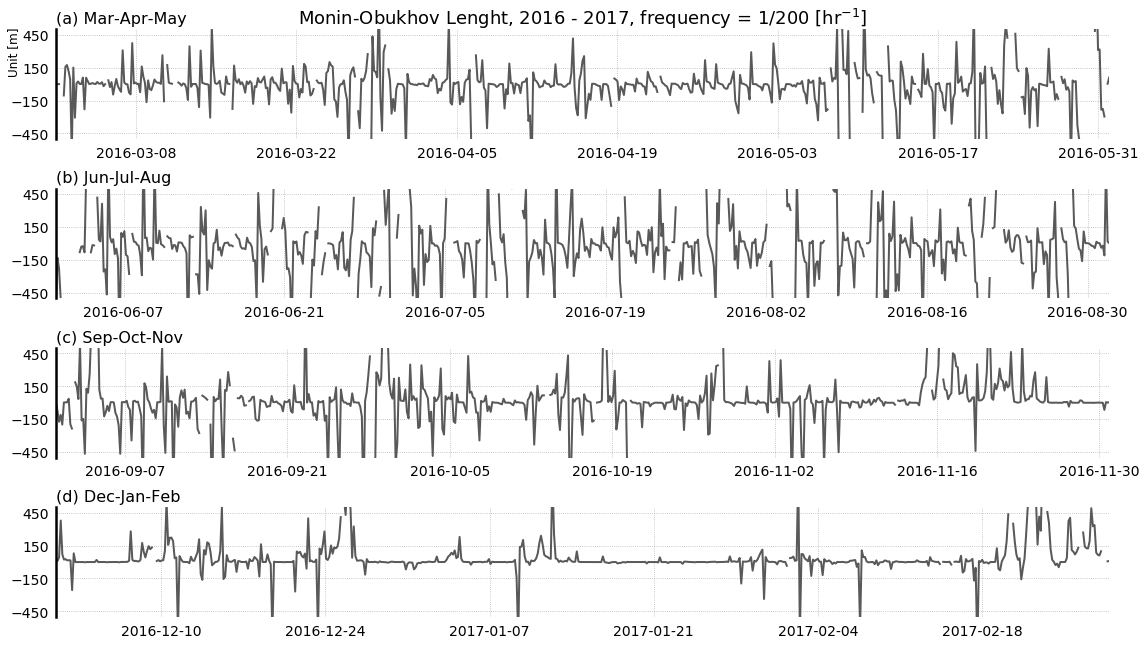

In [8]:
sec = [432, 1095, 1757, 2412, 3060]
title_wd = ['(a) Mar-Apr-May', '(b) Jun-Jul-Aug', '(c) Sep-Oct-Nov', '(d) Dec-Jan-Feb']
fig, AX = plt.subplots(4, 1, figsize=(16, 9))
AX = AX.flat
for i, ax in enumerate(AX):
    ax.grid(linestyle=':')
    ax.set_ylim([-525, 525])
    ax.set_yticks(range(-450, 600, 300))
    
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom="off", top="off", \
           labelbottom="on", left="off", right="off", labelleft="on")
    
    ax.set_ylim([-500, 500])
    ax.set_xlim([date_list_ave[sec[i]], date_list_ave[sec[i+1]-1]])
    ax.set_title(title_wd[i], fontsize=16, ha='left', x=0)
    ax.plot(date_list_ave[sec[i]:sec[i+1]], L_ave[sec[i]:sec[i+1]], color=B1, lw=2.0)

AX[0].text(0.5, 1.1, r"Monin-Obukhov Lenght, 2016 - 2017, frequency = 1/200 [hr$^{-1}$]", \
           va='center',ha='center', transform=AX[0].transAxes, fontsize=18)
AX[0].text(-0.04, .8, r"Unit [m]", \
           va='center',ha='center', rotation='vertical', transform=AX[0].transAxes, fontsize=12)
AX[-1].tick_params(labelbottom="on")
plt.tight_layout()

## Estimate the relation between $\zeta$ and $\phi_M$

**[Dyer [1974]](https://clouds.eos.ubc.ca/~phil/courses/atsc500/docs/Dyer-1974.pdf)**, provides the following relation:

$$
\phi_M = 
\begin{cases} 
1+5\zeta, & \mathrm{stable} \\ 
\left(1-16\zeta\right)^{-1/4}, & \mathrm{unstable} 
\end{cases}
$$

Here the Cesar data will be applied to verify this relation on 20 m and 100 m with:

$$
\zeta = \frac{\overline{z}}{L}
$$

$$
\phi_M = \frac{kz}{u^{*}}\frac{\partial\overline{U}}{\partial z}
$$

The obersrved wind profile was interpolated based on the following function:

$$
U = a_1 + a_2z + a_3z^2 + a_4\ln z
$$

### Interpolate wind profiles

In [9]:
from scipy.optimize import curve_fit

def wind_prof(z, *coef):
    '''
    Fit wind profile into a1+a2z+a3z^2+a4lnz
    '''
    fit = coef[0] + coef[1]*z + coef[2]*z*z + coef[3]*np.log(z)
    return fit

U_ave = U_ave[:, 1:] # !! <-- the surface U is filled with NaNs
U_interp = np.zeros([L1, 100])
z_interp = np.linspace(z[1], z[6], 100)
for i in range(L1):
    coef, _ = curve_fit(wind_prof, z[1:], U_ave[i, :], p0=np.zeros(4))
    U_interp[i, :] = wind_prof(z_interp, *coef)

### Calculate $\zeta$, $\phi_M$ and comparing with Dyer [1974] vals

In [10]:
def phi_obs(u, us, z, z_bar=20):
    '''
    estimate phi_m at z_bar
    z_bar must be in the range of [z.min(), z.max()]
    '''
    k = 0.4
    ind = np.searchsorted(z, 20)
    _, du = np.gradient(u, edge_order=2)
    dz = np.gradient(z, edge_order=2)
    dudz = (du/dz)[:, ind] 
    return k*z_bar*dudz/us

def zeta_obs(L, z_bar=20):
    '''
    z/L
    '''
    return z_bar/L

def Dyer(zeta):
    '''
    Calculate phi_M by Dyer [1974]
    '''
    phi_M = np.zeros(zeta.shape)*np.nan
    phi_M[zeta>0] = 1 + 5*zeta[zeta>0]
    phi_M[zeta<=0] = (1 - 16*zeta[zeta<=0])**-0.25
    return phi_M

In [11]:
zeta_Dyer = np.linspace(-60, 40, 100)
phi_Dyer = Dyer(zeta_Dyer)

In [12]:

def compare_z(z_bar, ax, xlim, ylim):
    phi_M = phi_obs(U_interp, Us_ave, z_interp, z_bar=z_bar)
    zeta = zeta_obs(L_ave, z_bar=z_bar)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(linestyle=':')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom="off", top="off", \
           labelbottom="on", left="off", right="off", labelleft="on")
    ax.plot(zeta, phi_M, 'k.', ms=6, mfc=B1, mec=B2, mew=0, label='Cesar')
    ax.plot(zeta_Dyer, phi_Dyer, '--', color=B2, lw=4.0, label='Dyer [1974]')

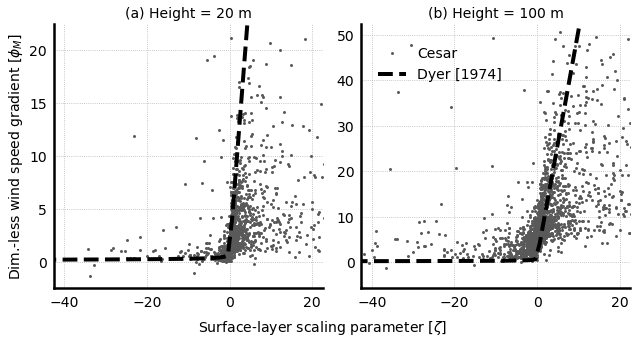

In [13]:
fig, AX = plt.subplots(1, 2, figsize=(9, 4.5))
AX = AX.flat 
compare_z(20, AX[0], [-42.5, 22.5], [-2.5, 22.5])
compare_z(100, AX[1], [-42.5, 22.5], [-5.75, 52.5])
#AX[1].spines["left"].set_visible(False)
#AX[1].tick_params(labelleft="off")
AX[0].set_title('(a) Height = 20 m', fontsize=14)
AX[1].set_title('(b) Height = 100 m', fontsize=14)
AX[0].set_ylabel('Dim.-less wind speed gradient [$\phi_M$]', fontsize=14)
AX[0].text(1.0, -0.15, r'Surface-layer scaling parameter [$\zeta$]', fontsize=14, \
           va='center',ha='center', transform=AX[0].transAxes)
LG = AX[1].legend(bbox_to_anchor=(0.57, 0.96), prop={'size':14}); LG.draw_frame(False)
plt.tight_layout()

The result agrees with **[Verkaik and Holtslag [2007]](https://link.springer.com/article/10.1007%2Fs10546-006-9121-1)**